# Final Homework

#### Joe Shymanski

#### Deadline: Monday December 18th 10:00 AM

In [1]:
# #Uncomment this cell to install the required packages
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install pgmpy
# !pip install scipy

In [2]:
from pgmpy.models import BayesianNetwork, MarkovNetwork
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination, BeliefPropagation
from pgmpy.factors.discrete import TabularCPD, DiscreteFactor
from scipy import stats
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [3]:
def plot_bayesian_network(model, variable_tags=None, variable_nodes=[], evidence={}):
    # Set up the layout for the Bayesian Network
    pos = nx.layout.circular_layout(model)
    
    # Prepare the color map based on evidence
    node_color_map = []
    for node in model.nodes():
        if node in evidence:
            if evidence[node] == model.get_cardinality(node) - 1:
                node_color_map.append('green')  # Green for evidence nodes with max value
            elif evidence[node] == 0:
                node_color_map.append('red')    # Red for evidence nodes with value 0
            else:
                node_color_map.append('orange') # Orange for all other evidence nodes
        elif node in variable_nodes:
            node_color_map.append('yellow')     # Yellow for all variable nodes
        else:
            node_color_map.append('white')
    
    # Draw the network
    nx.draw(
        model,
        pos,
        labels=variable_tags,
        with_labels=True,
        node_size=1000,
        node_color='white',
        font_size=10,
        arrows=True,
        arrowsize=20,
        width=2
    )
    
    # Draw nodes with custom node borders
    i = 0
    for node, (x, y) in pos.items():
        if variable_tags is None:
            plt.text(x, y, node, fontsize=10, ha='center', va='center',
                 bbox=dict(facecolor=node_color_map[i]))
        else:

            plt.text(x, y, variable_tags[node], fontsize=10, ha='center', va='center',
                    bbox=dict(facecolor=node_color_map[i]))
        i += 1

    # Show the plot
    plt.show()

In [4]:
def plot_markov_network(model, variable_tags=None, variable_nodes=[], evidence={}):
    # Set up the layout for the Markov Network
    pos = nx.layout.circular_layout(model)
    
    # Prepare the color map based on evidence
    node_color_map = []
    for node in model.nodes():
        if node in evidence:
            if evidence[node] == model.get_cardinality(node) - 1:
                node_color_map.append('green')  # Green for evidence nodes with max value
            elif evidence[node] == 0:
                node_color_map.append('red')    # Red for evidence nodes with value 0
            else:
                node_color_map.append('orange') # Orange for all other evidence nodes
        elif node in variable_nodes:
            node_color_map.append('yellow')     # Yellow for all variable nodes
        else:
            node_color_map.append('white')
    
    # Draw the network
    nx.draw(
        model,
        pos,
        labels=variable_tags,
        with_labels=True,
        node_size=1000,
        node_color='white',
        font_size=10,
        width=2
    )
    
    # Draw nodes with custom node borders (bbox parameter is not available in nx.draw())
    i = 0
    for node, (x, y) in pos.items():
        if variable_tags is None:
            plt.text(x, y, node, fontsize=10, ha='center', va='center',
                 bbox=dict(facecolor=node_color_map[i]))
        else:
            plt.text(x, y, variable_tags[node], fontsize=10, ha='center', va='center',
                    bbox=dict(facecolor=node_color_map[i]))
        i += 1

    # Show the plot
    plt.show()

## Question 1) Implementing a Directed Graphical Model:

See the following websites to find an interesting machine learning problem (a dataset) with at least 5
random variables (features):

https://archive.ics.uci.edu/datasets

https://www.kaggle.com/datasets

If you find your dataset using other sources, you can use your own dataset.

For that dataset:

### 1) Draw a directed graphical model (DGM)

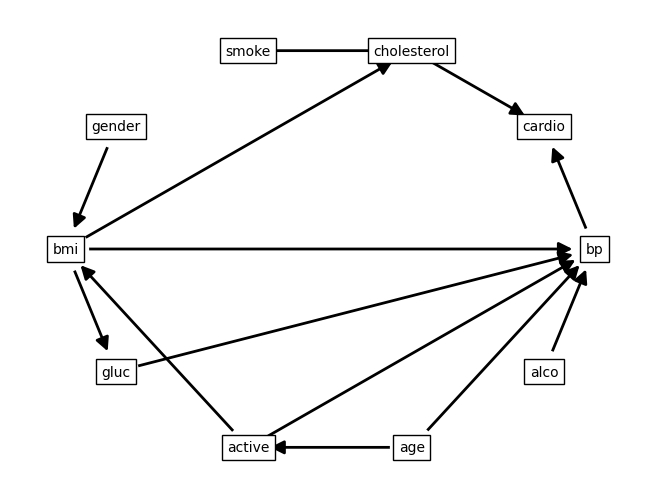

In [5]:
# Defining network structure for cardiovascular disease (CVD)
cvd_model = BayesianNetwork([
    # https://www.cdc.gov/chronicdisease/resources/publications/factsheets/heart-disease-stroke.htm
    ('bp','cardio'),('cholesterol','cardio'),
    # https://www.healthline.com/health/smoking-and-cholesterol
    ('smoke','cholesterol'),
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4184278
    ('gender','bmi'),
    # https://www.pennmedicine.org/updates/blogs/metabolic-and-bariatric-surgery-blog/2019/march/obesity-and-heart-disease
    ('bmi','cholesterol'),('bmi','bp'),('bmi','gluc'),
    # https://www.diabetes.org.uk/guide-to-diabetes/managing-your-diabetes/blood-pressure
    ('gluc','bp'),
    # https://www.health.ny.gov/diseases/chronic/cvd.htm
    ('active','bp'),
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7376490
    ('age','active'),
    # https://www.nia.nih.gov/health/high-blood-pressure/high-blood-pressure-and-older-adults
    ('age','bp'),
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3017964
    ('active','bmi'),
    # https://www.bhf.org.uk/informationsupport/heart-matters-magazine/medical/effects-of-alcohol-on-your-heart
    ('alco','bp')
])

# Plot the network
plot_bayesian_network(cvd_model)

### 2) Write at least 4 conditional independence rules for the proposed DGM

cardio ⫫ smoke | cholesterol

cardio ⫫ alco | bp

cardio ⫫ gender | bmi

gluc ⫫ cholesterol | bmi

### 3) Show the Markov Blanket of 3 nodes in your graph

In [6]:
cvd_model.get_markov_blanket('cardio')

['bp', 'cholesterol']

In [7]:
cvd_model.get_markov_blanket('bmi')

['smoke', 'bp', 'alco', 'active', 'age', 'gender', 'cholesterol', 'gluc']

In [8]:
cvd_model.get_markov_blanket('bp')

['alco', 'active', 'cardio', 'bmi', 'age', 'cholesterol', 'gluc']

### 4) Train your model using the dataset

Load in the dataset found here: https://www.kaggle.com/datasets/akshatshaw7/cardiovascular-disease-dataset.

In [9]:
cvd_data = pd.read_csv('health_data.csv', usecols=range(1,14))

Convert data types.

In [10]:
cvd_data['id'] = cvd_data['id'].astype('uint32')
cvd_data['gender'] = cvd_data['gender'].astype('uint8')
cvd_data['cholesterol'] = cvd_data['cholesterol'].astype('uint8')
cvd_data['gluc'] = cvd_data['gluc'].astype('uint8')
cvd_data['smoke'] = cvd_data['smoke'].astype('uint8')
cvd_data['alco'] = cvd_data['alco'].astype('uint8')
cvd_data['active'] = cvd_data['active'].astype('uint8')
cvd_data['cardio'] = cvd_data['cardio'].astype('uint8')

Convert the units of measurement.

In [11]:
cvd_data['age'] /= 365.25 # days to years
cvd_data['height'] /= 30.48 # centimeters to feet
cvd_data['weight'] *= 2.20462 # kilograms to pounds

Add BMI.

In [12]:
cvd_data['bmi'] = 703*cvd_data['weight']/(cvd_data['height']*12)**2

Limit blood pressure to plausible values.

In [13]:
# Limit blood pressure to plausible values
cvd_data = cvd_data[
    cvd_data['ap_hi'].between(0, 400) &
    cvd_data['ap_lo'].between(0, 400) &
    cvd_data['ap_hi'].gt(cvd_data['ap_lo'])
]

Discretize the blood pressure measurements using this definition: https://www.nhs.uk/common-health-questions/lifestyle/what-is-blood-pressure.

In [14]:
cvd_data['ap_hi'] = pd.cut(cvd_data['ap_hi'], bins=[0,140,400], labels=range(2), right=False).astype('uint8')
cvd_data['ap_lo'] = pd.cut(cvd_data['ap_lo'], bins=[0,90,400], labels=range(2), right=False).astype('uint8')
cvd_data['bp'] = cvd_data[['ap_hi','ap_lo']].any(axis=1).astype('uint8')

Discretize the remaining continuous data.

In [15]:
cvd_data['age'] = pd.cut(cvd_data['age'], bins=[0,45,55,100], labels=range(3), right=False).astype('uint8')
cvd_data['bmi'] = pd.cut(cvd_data['bmi'], bins=[0,25,30,1000], labels=range(3), right=False).astype('uint8')

Train the model from the dataset.

In [16]:
cvd_model.fit(cvd_data)

Print the conditional probability distribution (CPD) tables.

In [17]:
for cpd in cvd_model.get_cpds():
    print(f"CPD of {cpd.variable}")
    print(cpd)

CPD of bp
+--------+---------------------+-----+--------------------+
| active | active(0)           | ... | active(1)          |
+--------+---------------------+-----+--------------------+
| age    | age(0)              | ... | age(2)             |
+--------+---------------------+-----+--------------------+
| alco   | alco(0)             | ... | alco(1)            |
+--------+---------------------+-----+--------------------+
| bmi    | bmi(0)              | ... | bmi(2)             |
+--------+---------------------+-----+--------------------+
| gluc   | gluc(0)             | ... | gluc(2)            |
+--------+---------------------+-----+--------------------+
| bp(0)  | 0.8619854721549637  | ... | 0.3283582089552239 |
+--------+---------------------+-----+--------------------+
| bp(1)  | 0.13801452784503632 | ... | 0.6716417910447762 |
+--------+---------------------+-----+--------------------+
CPD of cardio
+-------------+---------------------+-----+---------------------+
| bp      

### 5) Do inference in your model. Show the probability density of your query random variable(s) given your evidence random variable(s).

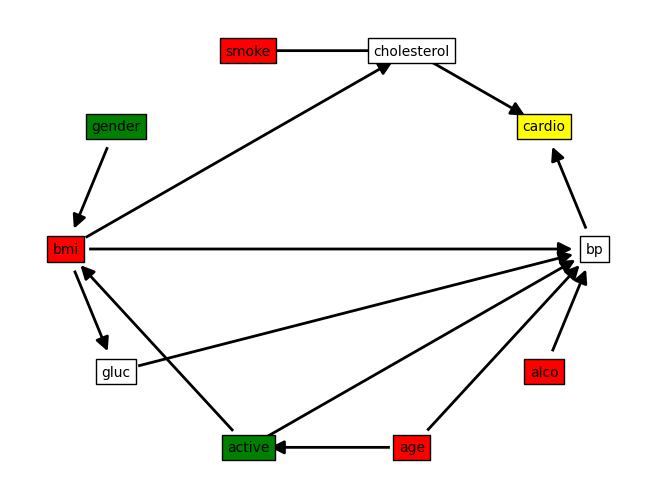

+-----------+---------------+
| cardio    |   phi(cardio) |
+===========+===============+
| cardio(0) |        0.6027 |
+-----------+---------------+
| cardio(1) |        0.3973 |
+-----------+---------------+


In [18]:
# My known statistics
evidence = {'age': 0, 'bmi': 0, 'gender': 1, 'smoke': 0, 'alco': 0, 'active': 1}
variable_nodes = ['cardio']

plot_bayesian_network(cvd_model, variable_tags=None, variable_nodes= variable_nodes, evidence=evidence)

# Perform inference
inference = VariableElimination(cvd_model)

# Computing the probability of variable given evidence
result = inference.query(variables=variable_nodes, evidence=evidence)
print(result)

### 6) Write a variable elimination node order for your DGM and show variable elimination.

Eliminating cardio


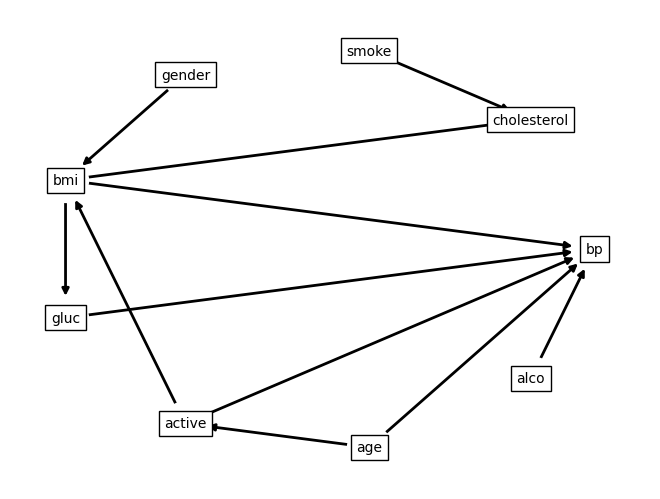

Eliminating smoke


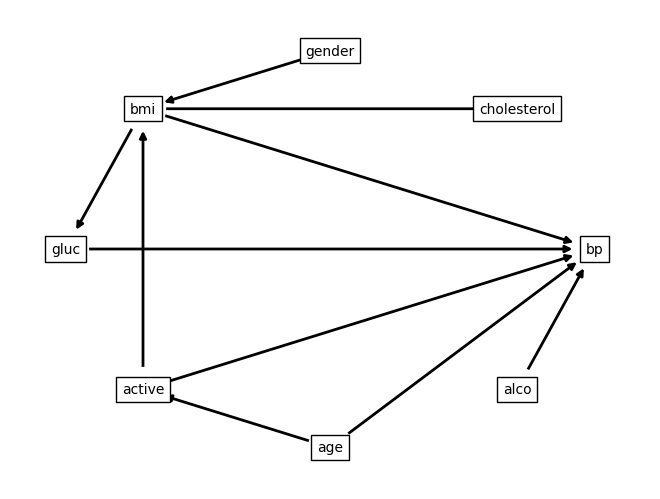

Eliminating gender


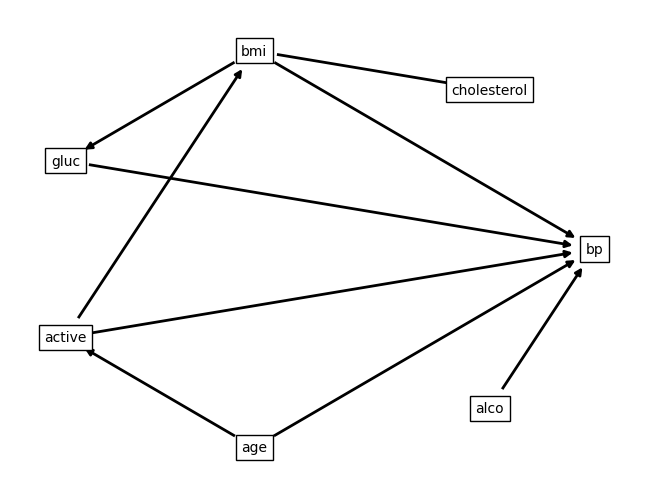

Eliminating cholesterol


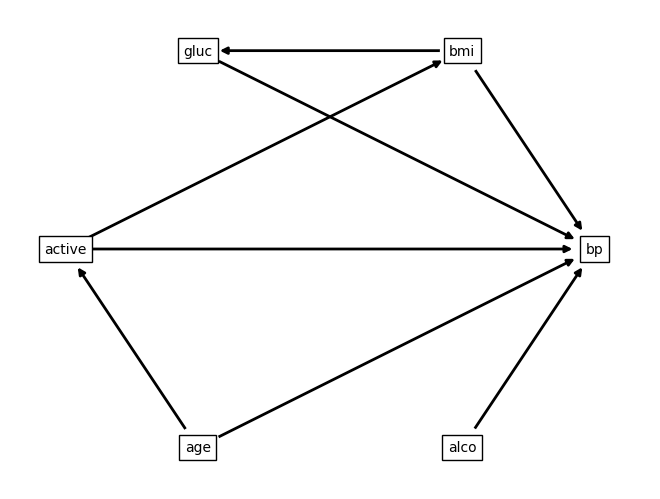

Eliminating alco


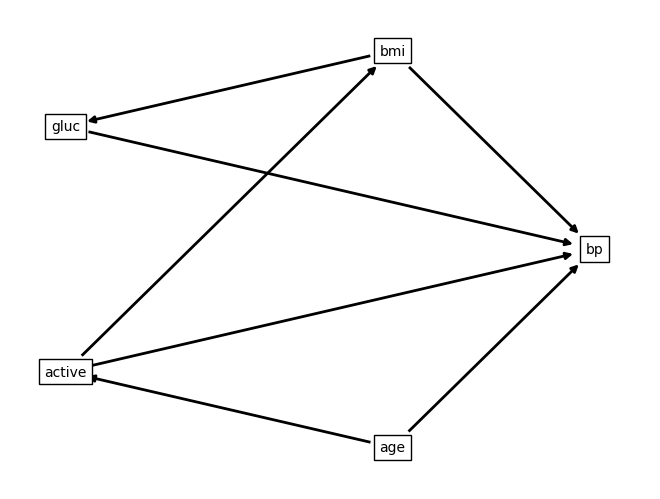

Eliminating bp


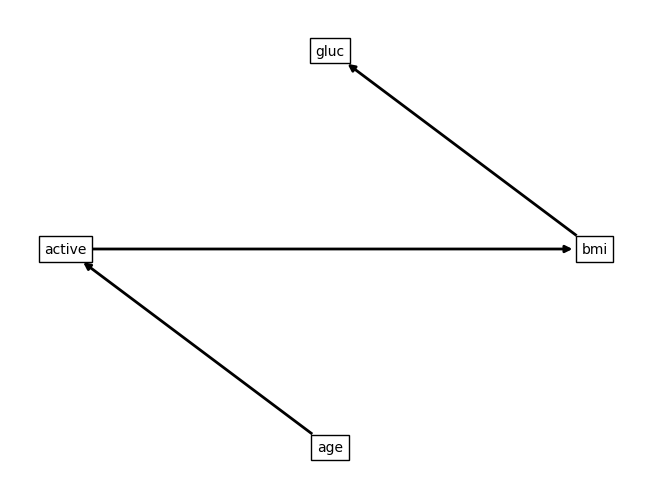

Eliminating gluc


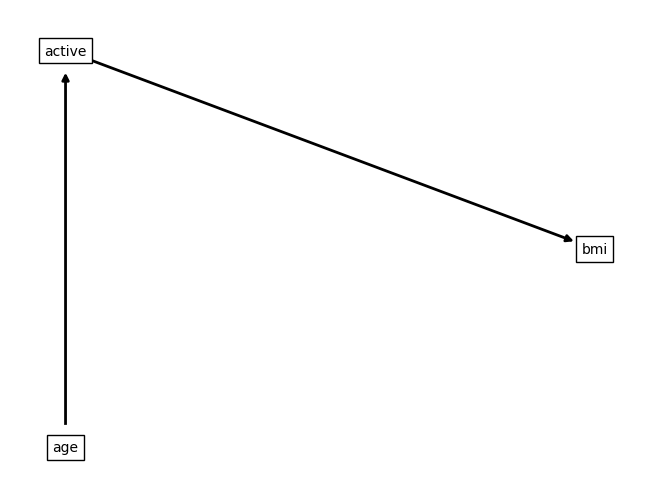

Eliminating bmi


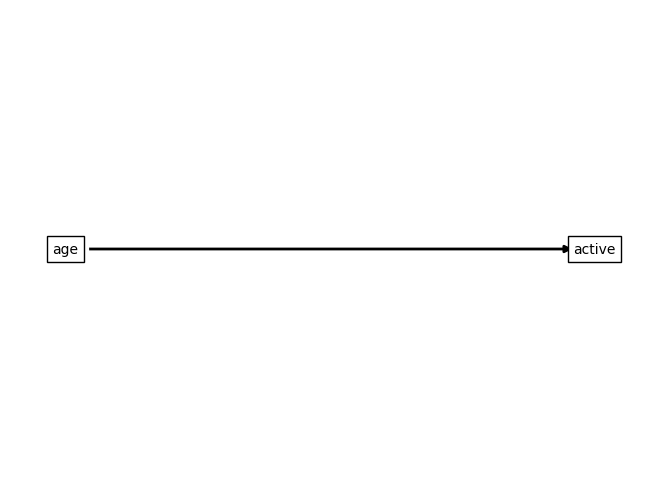

Eliminating active


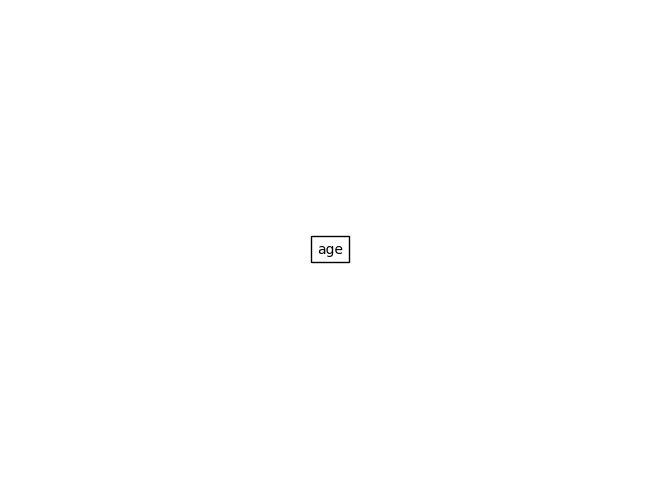

Eliminating age


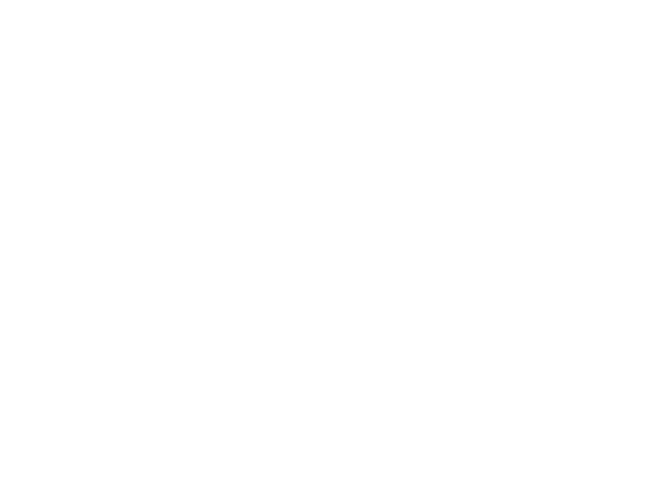

In [19]:
elimination_order = ['cardio','smoke','gender','cholesterol','alco','bp','gluc','bmi','active','age']
elimination_model = cvd_model.copy()
for node in elimination_order:
    print('Eliminating', node)
    nbrs = list(elimination_model[node])
    for i in range(len(nbrs)):
        for j in range(i + 1, len(nbrs)):
            elimination_model.add_edge(nbrs[i], nbrs[j])
#             survey_model.add_edge(nbrs[i], nbrs[j])
    elimination_model.remove_node(node)
    plot_markov_network(elimination_model)
# plot_markov_network(survey_model)

## Question 2) Implementing an Undirected Graphical Model:

### 1) Draw an undirected graphical model (UGM).

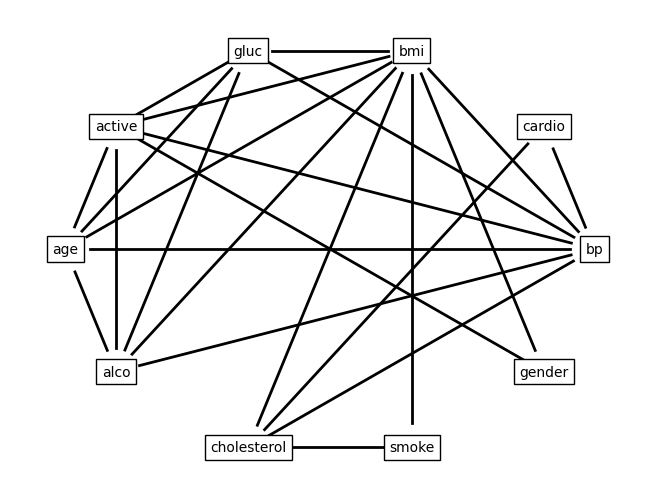

+-------+-----------+--------+---------+--------+---------+------------------------------------+
| bp    | active    | age    | alco    | bmi    | gluc    |   phi(bp,active,age,alco,bmi,gluc) |
+=======+===========+========+=========+========+=========+====================================+
| bp(0) | active(0) | age(0) | alco(0) | bmi(0) | gluc(0) |                             0.8620 |
+-------+-----------+--------+---------+--------+---------+------------------------------------+
| bp(0) | active(0) | age(0) | alco(0) | bmi(0) | gluc(1) |                             0.9211 |
+-------+-----------+--------+---------+--------+---------+------------------------------------+
| bp(0) | active(0) | age(0) | alco(0) | bmi(0) | gluc(2) |                             0.8519 |
+-------+-----------+--------+---------+--------+---------+------------------------------------+
| bp(0) | active(0) | age(0) | alco(0) | bmi(1) | gluc(0) |                             0.7621 |
+-------+-----------+--------+

In [20]:
cvd_model_undirected = cvd_model.to_markov_model()

plot_markov_network(cvd_model_undirected)
for factor in cvd_model_undirected.get_factors():
    print(factor)

### 2) Write at least 4 conditional independence rules in your graph.

Done in the previous section.

### 3) Train the model using the dataset (train the potential functions of the cliques).

Done in the previous section.

### 4) Do inference in your model. Show the probability density of your query random variable(s) given your evidence random variable(s).

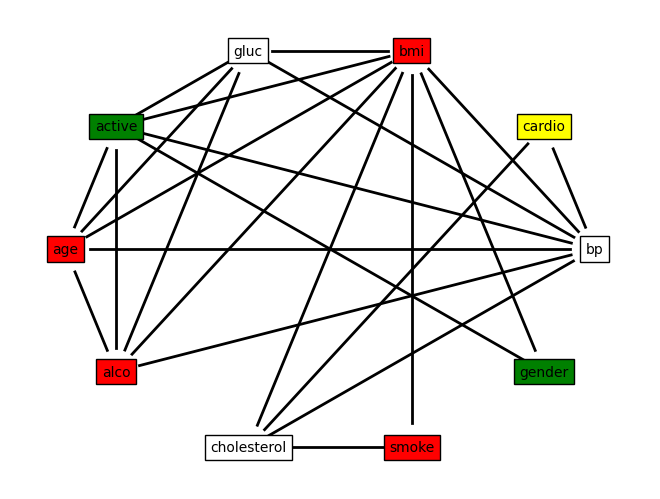

+-----------+---------------+
| cardio    |   phi(cardio) |
+===========+===============+
| cardio(0) |        0.6027 |
+-----------+---------------+
| cardio(1) |        0.3973 |
+-----------+---------------+


In [21]:
# My known statistics
evidence = {'age': 0, 'bmi': 0, 'gender': 1, 'smoke': 0, 'alco': 0, 'active': 1}
variable_nodes = ['cardio']

plot_markov_network(cvd_model_undirected, variable_tags=None, variable_nodes=variable_nodes, evidence=evidence)

# Perform inference
inference = BeliefPropagation(cvd_model)

# Computing the probability of variable given evidence
result = inference.query(variables=variable_nodes, evidence=evidence)
print(result)

### 5) Write a junction tree for your graph.

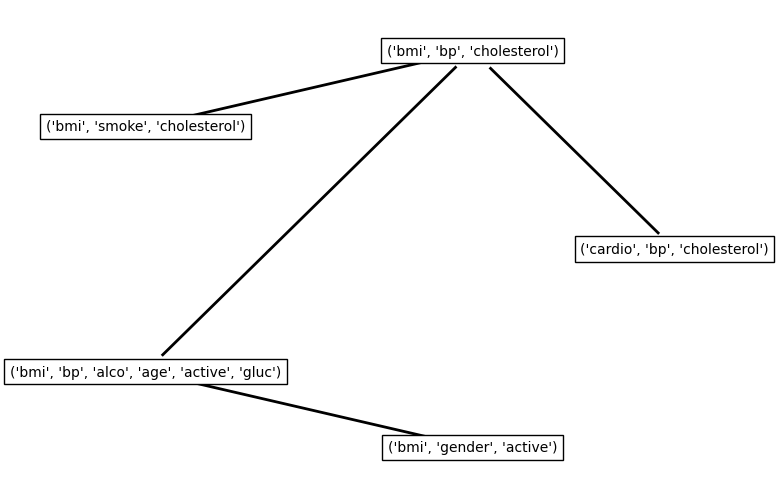

In [22]:
cvd_model_junction = cvd_model_undirected.to_junction_tree()
plot_markov_network(cvd_model_junction)

### 6) Write a variable elimination node order for your UGM and show variable elimination. 

Eliminating cardio


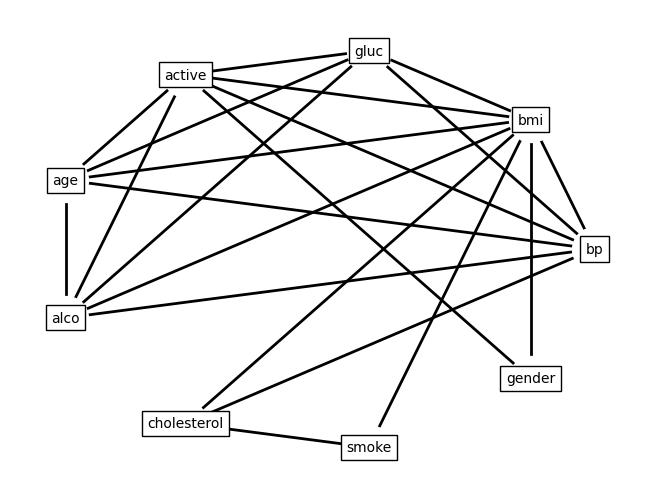

Eliminating smoke


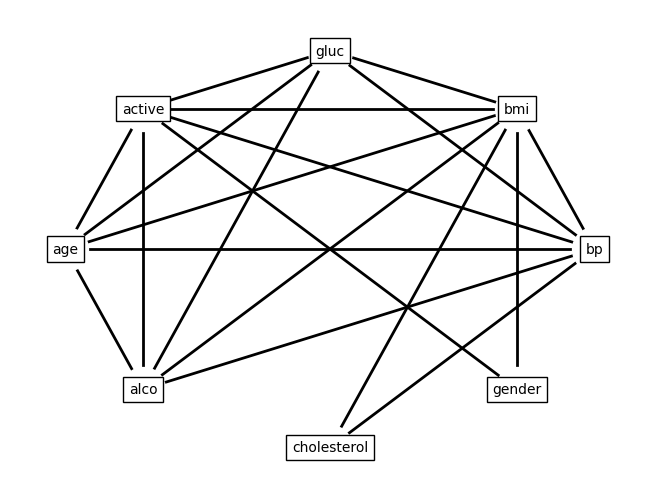

Eliminating gender


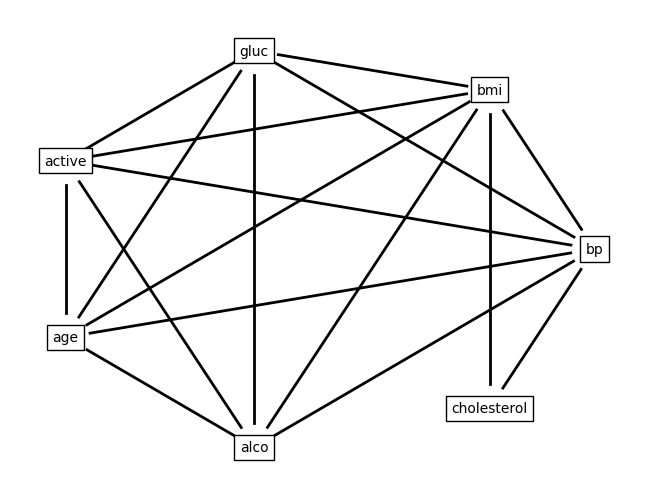

Eliminating cholesterol


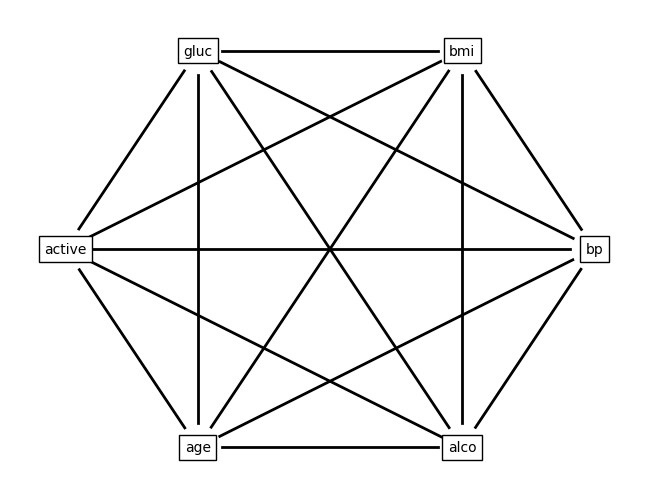

Eliminating alco


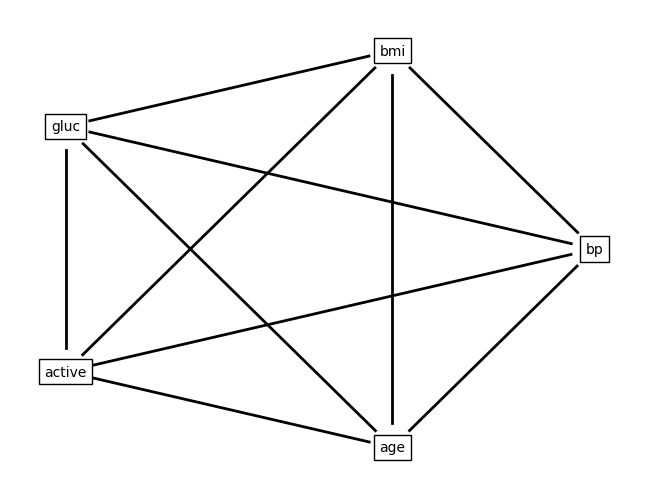

Eliminating bp


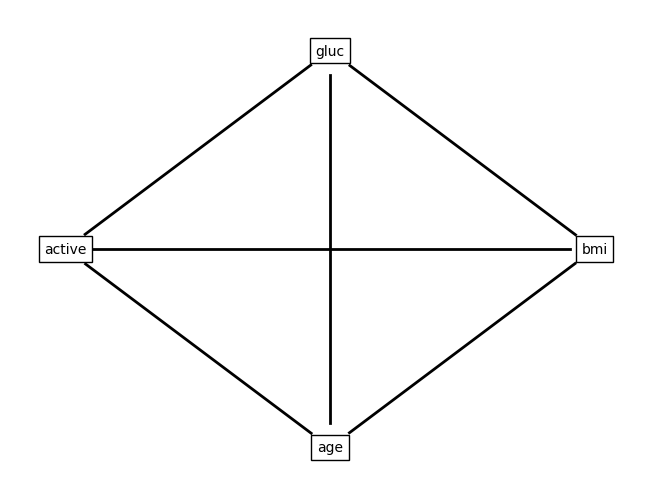

Eliminating gluc


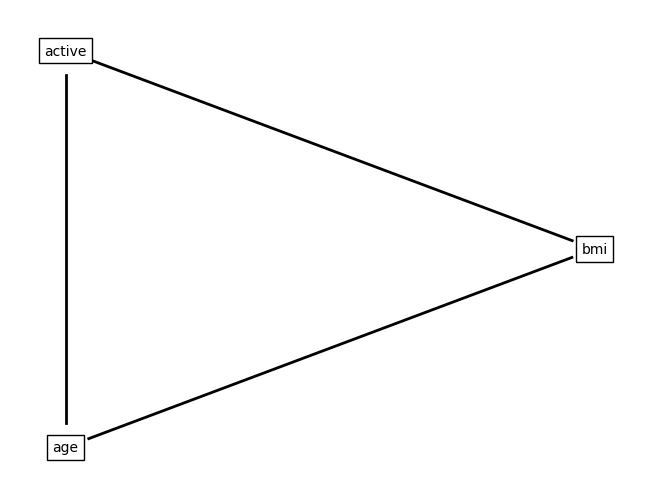

Eliminating bmi


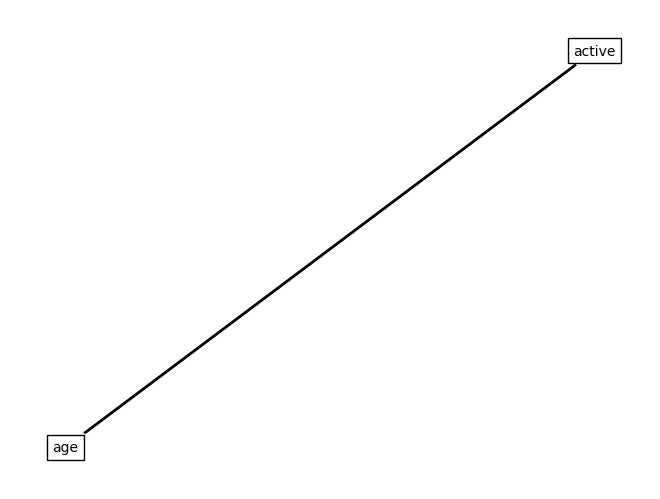

Eliminating active


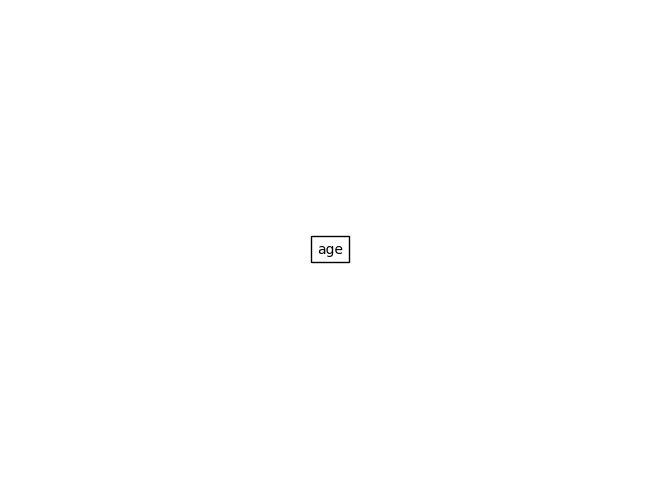

Eliminating age


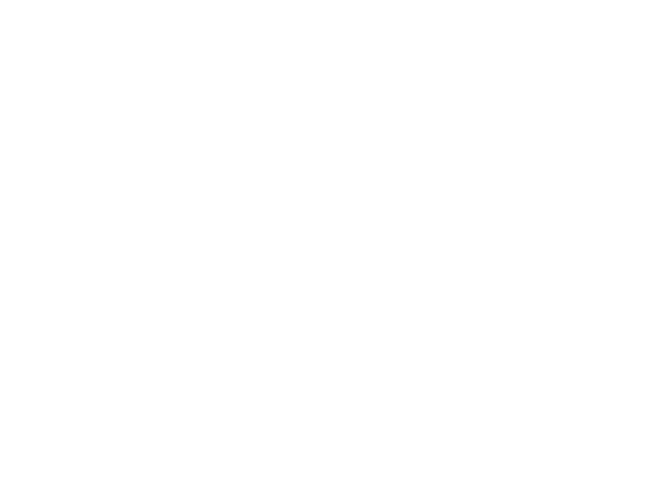

In [23]:
elimination_order = ['cardio','smoke','gender','cholesterol','alco','bp','gluc','bmi','active','age']
elimination_model = cvd_model_undirected.copy()
for node in elimination_order:
    print('Eliminating', node)
    nbrs = list(elimination_model[node])
    for i in range(len(nbrs)):
        for j in range(i + 1, len(nbrs)):
            elimination_model.add_edge(nbrs[i], nbrs[j])
#             survey_model.add_edge(nbrs[i], nbrs[j])
    elimination_model.remove_node(node)
    plot_markov_network(elimination_model)
# plot_markov_network(survey_model)